# Gravitational orbits in Cartesian coordinates
---
*04/30/2021 -- Jessica Kulp -- kulp.95@osu.edu*
#### In this notebook:
* Defines a GravitationalOrbits class to solve the two-body problem for gravitational attraction between two bodies in Cartesian coordinates.
* Plots the orbits for the two bodies in Cartesian coordinates.
* Shows that the problem reduces to the orbits we considered in class if one of the bodies is very heavy and you are in its rest frame.
* Creates widgets to vary the masses of the two bodies.
* Uses the Leapfrog method, showing that it conserves energy (whereas using a SciPy ODE solver, like solve_ivp, does not).

First we import the modules we need.

In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Then we define the **GravitationalOrbits** class.

In [2]:
class GravitationalOrbits():
    '''
    The GravitationalOrbits class contains the parameters and Lagrange's equations for 
    two bodies orbiting due to gravitational attraction.
    _____________
    Parameters:
    m1 -- float, mass of first body 
    m2 -- float, mass of second body
    G  -- float, gravitational constant
    _____________
    Methods: 
    dz_dt(t, z) -- Returns the right side of the differential equation at a given time, t, and z value.
    
    '''
    def __init__(self, m1=1., m2=1., G=1.):
        '''
        Initializes the class attributes. 
        '''
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dz_dt(self, t, z):
        '''
        Returns the right side of the differential equation:
        [dz/dt, d^2z/dt^2]
        ______________
        Parameters: 
        t -- float, time
        z -- float, vector where
             z[0] = x1, z[1] = x1_dot, z[2] = y1, z[3] = y1_dot
             z[4] = x2, z[5] = x2_dot, z[6] = y2, z[7] = y2_dot
        ______________
        Returns: 
        '''
        r12 = np.sqrt( (z[4]-z[0])**2. + (z[6]-z[2])**2. )  # distance between bodies
        a1 = self.G * self.m2 / r12**3.                     
        a2 = -self.G * self.m1 / r12**3.
        x12 = z[4] - z[0]
        y12 = z[6] - z[2]
        
        return [z[1], a1*x12, z[3], a1*y12, z[5], a2*x12, z[7], a2*y12]
    
    def solve_ode(self, t_pts, z_0, method='RK23', abserr=1.0e-10, relerr=1.0e-10):
        '''
        Solves the ODE given initial conditions using solve_ivp.
        '''
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method=method,
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def leapfrog(self, t_pts, z_0):
        '''
        Solves the ODE given initial conditions using Leapfrog method.
        '''
        delta_t = t_pts[1] - t_pts[0]
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = z_0
    
        # Create arrays with zeros, same length as t_pts
        num = len(t_pts)
        x1 = np.zeros(num)
        y1 = np.zeros(num)
        x2 = np.zeros(num)
        y2 = np.zeros(num)
        x1_dot = np.zeros(num)
        y1_dot = np.zeros(num)
        x2_dot = np.zeros(num)
        y2_dot = np.zeros(num)
        x1_dot_half = np.zeros(num)
        y1_dot_half = np.zeros(num)
        x2_dot_half = np.zeros(num)
        y2_dot_half = np.zeros(num)
        
        # Set up initial conditions
        x1[0] = x1_0
        y1[0] = y1_0
        x2[0] = x2_0
        y2[0] = y2_0
        x1_dot[0] = x1_dot_0
        y1_dot[0] = y1_dot_0
        x2_dot[0] = x2_dot_0
        y2_dot[0] = y2_dot_0
        
        # Step through diff eq
        for i in np.arange(num - 1):
            t = t_pts[i]
            z = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
           
            x1_dot_half[i] = x1_dot[i] + self.dz_dt(t,z)[1] * delta_t / 2.
            y1_dot_half[i] = y1_dot[i] + self.dz_dt(t,z)[3] * delta_t / 2.
            x2_dot_half[i] = x2_dot[i] + self.dz_dt(t,z)[5] * delta_t / 2.
            y2_dot_half[i] = y2_dot[i] + self.dz_dt(t,z)[7] * delta_t / 2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            x1_dot[i+1] = x1_dot_half[i] + self.dz_dt(t,z)[1] * delta_t / 2.
            y1_dot[i+1] = y1_dot_half[i] + self.dz_dt(t,z)[3] * delta_t / 2.
            x2_dot[i+1] = x2_dot_half[i] + self.dz_dt(t,z)[5] * delta_t / 2.
            y2_dot[i+1] = y2_dot_half[i] + self.dz_dt(t,z)[7] * delta_t / 2.
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot

Now we define a function for plotting.

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

And a function which returns stop and start indices for plotting. 

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

Getting ready to plot, we define labels for the axes, the plotting time, and the parameters, and instantiate a GravitationalOrbits object.

In [5]:
# Labels for individual plot axes
orbit_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m1 = 1.
m2 = 5.

# Instantiate orbit object
o1 = GravitationalOrbits(m1=m1, m2=m2, G=G)

Finally, define the initial conditions, solve given the initial conditions using **solve_ode()** (defined in the class), and plot $\phi_i(t)$ vs $t$.

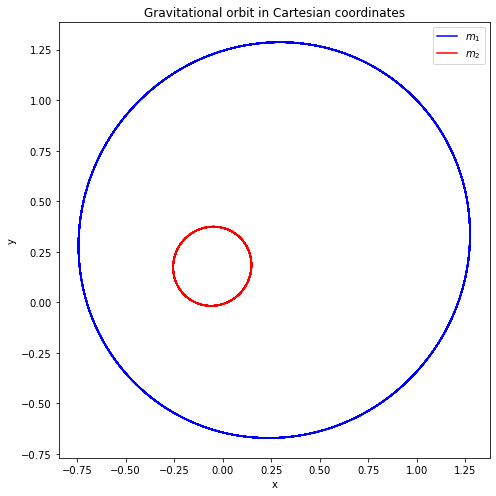

In [6]:
# Set initial conditions so that CM is initially at rest
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1*x1_0/m2, -m1*x1_dot_0/m2
y2_0, y2_dot_0 = -m1*x2_0/m2, -m1*y1_dot_0/m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve given the initial conditions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Gravitational orbit in Cartesian coordinates')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

fig.tight_layout()
fig.savefig('Orbits.png', bbox_inches='tight')

Now we see the orbits of the two bodies, $m_1$ and $m_2$. Next we can show that the problem reduces to the orbits we considered in class if one body is very heavy and you are in its rest frame. We have already made the initial conditions such that we are in the rest frame, so now we just need to change the masses to see this. 

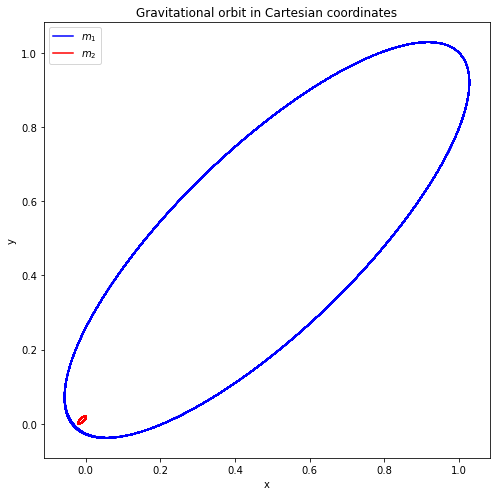

In [7]:
# change parameters to have one very heavy body
m1 = 1.
m2 = 50.

# Instantiate orbit object
o2 = GravitationalOrbits(m1=m1, m2=m2, G=G)

# Set initial conditions so that CM is initially at rest
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1*x1_0/m2, -m1*x1_dot_0/m2
y2_0, y2_dot_0 = -m1*x2_0/m2, -m1*y1_dot_0/m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve given the initial conditions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Gravitational orbit in Cartesian coordinates')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

fig.tight_layout()
fig.savefig('Orbits2.png', bbox_inches='tight')

As expected, we see that in this case, the orbits are eliptical and much like those we saw in class.    

## Widgets
Now let's add sliding widgets for the masses. First import the necessary modules.

In [8]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 
from IPython.display import display

Now we define a function to update the plot when a slider is moved. It will call **solve_ode** each time with the new masses and initial conditions and replot with the new results.

In [9]:
def update_plot(m1=1., m2=5.):
    """
    Update the plot, which includes a call to the solve_ode function.
    """
    t_start = 0.
    t_end = 15.
    delta_t = 0.001
    t_pts = np.arange(t_start, t_end+delta_t, delta_t)
    
    # Instantiate orbit object with the new parameters
    o3 = GravitationalOrbits(m1=m1, m2=m2, G=G)
                 
    # Set initial conditions so that CM is initially at rest
    x1_0, x1_dot_0 = 1., -1.
    y1_0, y1_dot_0 = 1., 1.
    x2_0, x2_dot_0 = -m1*x1_0/m2, -m1*x1_dot_0/m2
    y2_0, y2_dot_0 = -m1*x2_0/m2, -m1*y1_dot_0/m2

    z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

    # Solve given the new initial conditions
    x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o3.solve_ode(t_pts, z_0)
    
    # replot both angles
    fig = plt.figure()
    fig = plt.figure(figsize=(5,5)) 
    ax = fig.add_subplot(1, 1, 1)
    line1, = ax.plot(x1, y1, lw=2, color='blue')
    line2, = ax.plot(x2, y2, lw=2, color='red')

Now we make the slider widgets for $m_1$ and $m_2$ and set up the **interactive_output** function.

In [10]:
m1 = FloatSlider(value=1., min=0., max=100., step=1.,
                      description=r'$m_1$ :')
m2 = FloatSlider(value=5., min=0., max=100., step=1.,
                      description=r'$m_2$ :')

plot_out = widgets.interactive_output(update_plot, dict(m1=m1, m2=m2))

Finally, set up the layout of the widgets and display it.

In [11]:
UI_box = VBox([m1, m2, plot_out])
display(UI_box)

Now we can change the masses using the widgets. You can see what happens to the orbits as one becomes much more massive. Be sure to give it enough time to update the plot after each change.

## Leapfrog method
Let's see what changes when we use the Leapfrog method for solving the differential equations. A function to carry out the Leapfrog method has been defined in the GravitationalOrbits class. We expect that the Leapfrog method with conserve energy, unlike using solve_ivp.

In [12]:
# Labels for individual plot axes
orbit_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 30.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1.
m1 = 1.
m2 = 5.

# Instantiate orbit object
o4 = GravitationalOrbits(m1=m1, m2=m2, G=G)

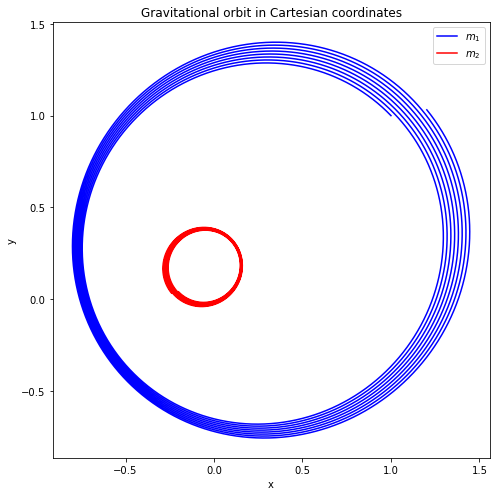

In [13]:
# Set initial conditions so that CM is initially at rest
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -m1*x1_0/m2, -m1*x1_dot_0/m2
y2_0, y2_dot_0 = -m1*x2_0/m2, -m1*y1_dot_0/m2

z_0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

# Solve given the initial conditions using Leapfrog method
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o4.leapfrog(t_pts, z_0)

# Start the plot!
fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(1,1,1)                  

# Get start/stop indices and plot orbit 
start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x1, y1, color='blue', label=r'$m_1$')
ax.plot(x2, y2, color='red', label=r'$m_2$')
ax.set_title('Gravitational orbit in Cartesian coordinates')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

fig.tight_layout()
fig.savefig('Orbits.png', bbox_inches='tight')

When we used solve_ivp, it resulted in a stable orbit, whereas for the Leapfrog method we see instability. As expected, we see that the Leapfrog method conserves energy whereas using solve_ivp does not. 